## California Housing Dataset
Task: Predict the median housing value per district

In [74]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
cal_housing = fetch_california_housing(as_frame=True)
dataset = cal_housing.frame

In [44]:
dataset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Label Preparation
- Incorrect label data needs to be corrected or its rows removed.
- This should be done before the train-test-split, as it affects train- and test-data
- These modifications are not part of the pipeline, as future data for prediction does not contain labels

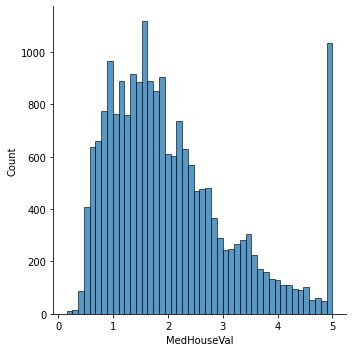

In [60]:
# Histogram
sns.displot(data=dataset, x="MedHouseVal", )
plt.show()

MedHauseVal is capped at 5, so these rows will be removed

In [61]:
dataset = dataset.drop(dataset[dataset['MedHouseVal'] >= 5].index)

## Split train/test and features/labels

In [62]:
data_train, data_test = train_test_split(dataset, test_size=0.2, random_state=99)
X_train = data_train.drop(['MedHouseVal'], axis='columns')
y_train = data_train['MedHouseVal']
X_test = data_test.drop(['MedHouseVal'], axis='columns')
y_test = data_test['MedHouseVal']

# Check shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15718, 8), (15718,), (3930, 8), (3930,))

In [48]:
data_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
2143,2.2467,27.0,4.590703,1.073696,2254.0,2.555556,36.78,-119.74,0.707
5713,3.8068,34.0,4.630996,0.987085,1516.0,2.797048,34.22,-118.25,2.670
11525,3.8038,22.0,4.574324,1.073480,2260.0,1.908784,33.72,-118.05,1.745
2343,4.8100,15.0,6.540594,1.013861,1687.0,3.340594,36.82,-119.69,0.936
16735,4.1146,41.0,4.938998,1.058824,1045.0,2.276688,37.68,-122.40,2.722


In [49]:
data_train.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,15718.000000,15718.000000,15718.000000,15718.000000,15718.000000,15718.000000,15718.000000,15718.000000,15718.000000
mean,3.673742,28.346291,5.370947,1.099563,1443.223693,3.049133,35.649076,-119.560714,1.922525
std,1.562459,12.514994,2.416263,0.484424,1154.561485,6.590787,2.150046,2.005257,0.968860
min,0.499900,1.000000,1.000000,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.525950,18.000000,4.411524,1.006090,798.000000,2.442454,33.930000,-121.750000,1.169250
50%,3.447150,28.000000,5.186241,1.048780,1178.000000,2.832963,34.260000,-118.500000,1.739000
75%,4.583300,37.000000,5.974454,1.099985,1745.750000,3.300258,37.730000,-117.990000,2.482000
max,15.000100,52.000000,132.533333,34.066667,35682.000000,599.714286,41.950000,-114.490000,4.991000


In [50]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15718 entries, 2143 to 14101
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       15718 non-null  float64
 1   HouseAge     15718 non-null  float64
 2   AveRooms     15718 non-null  float64
 3   AveBedrms    15718 non-null  float64
 4   Population   15718 non-null  float64
 5   AveOccup     15718 non-null  float64
 6   Latitude     15718 non-null  float64
 7   Longitude    15718 non-null  float64
 8   MedHouseVal  15718 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


## Feature Selection

<AxesSubplot:>

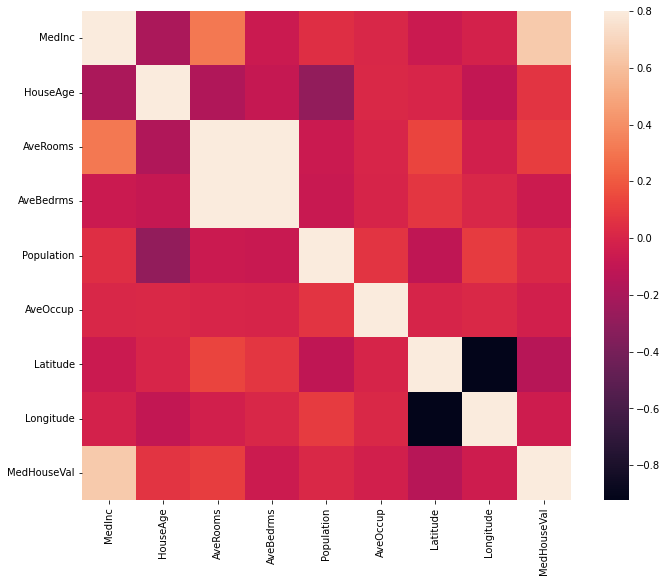

In [55]:
# Correlation matrix
corrmat = data_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

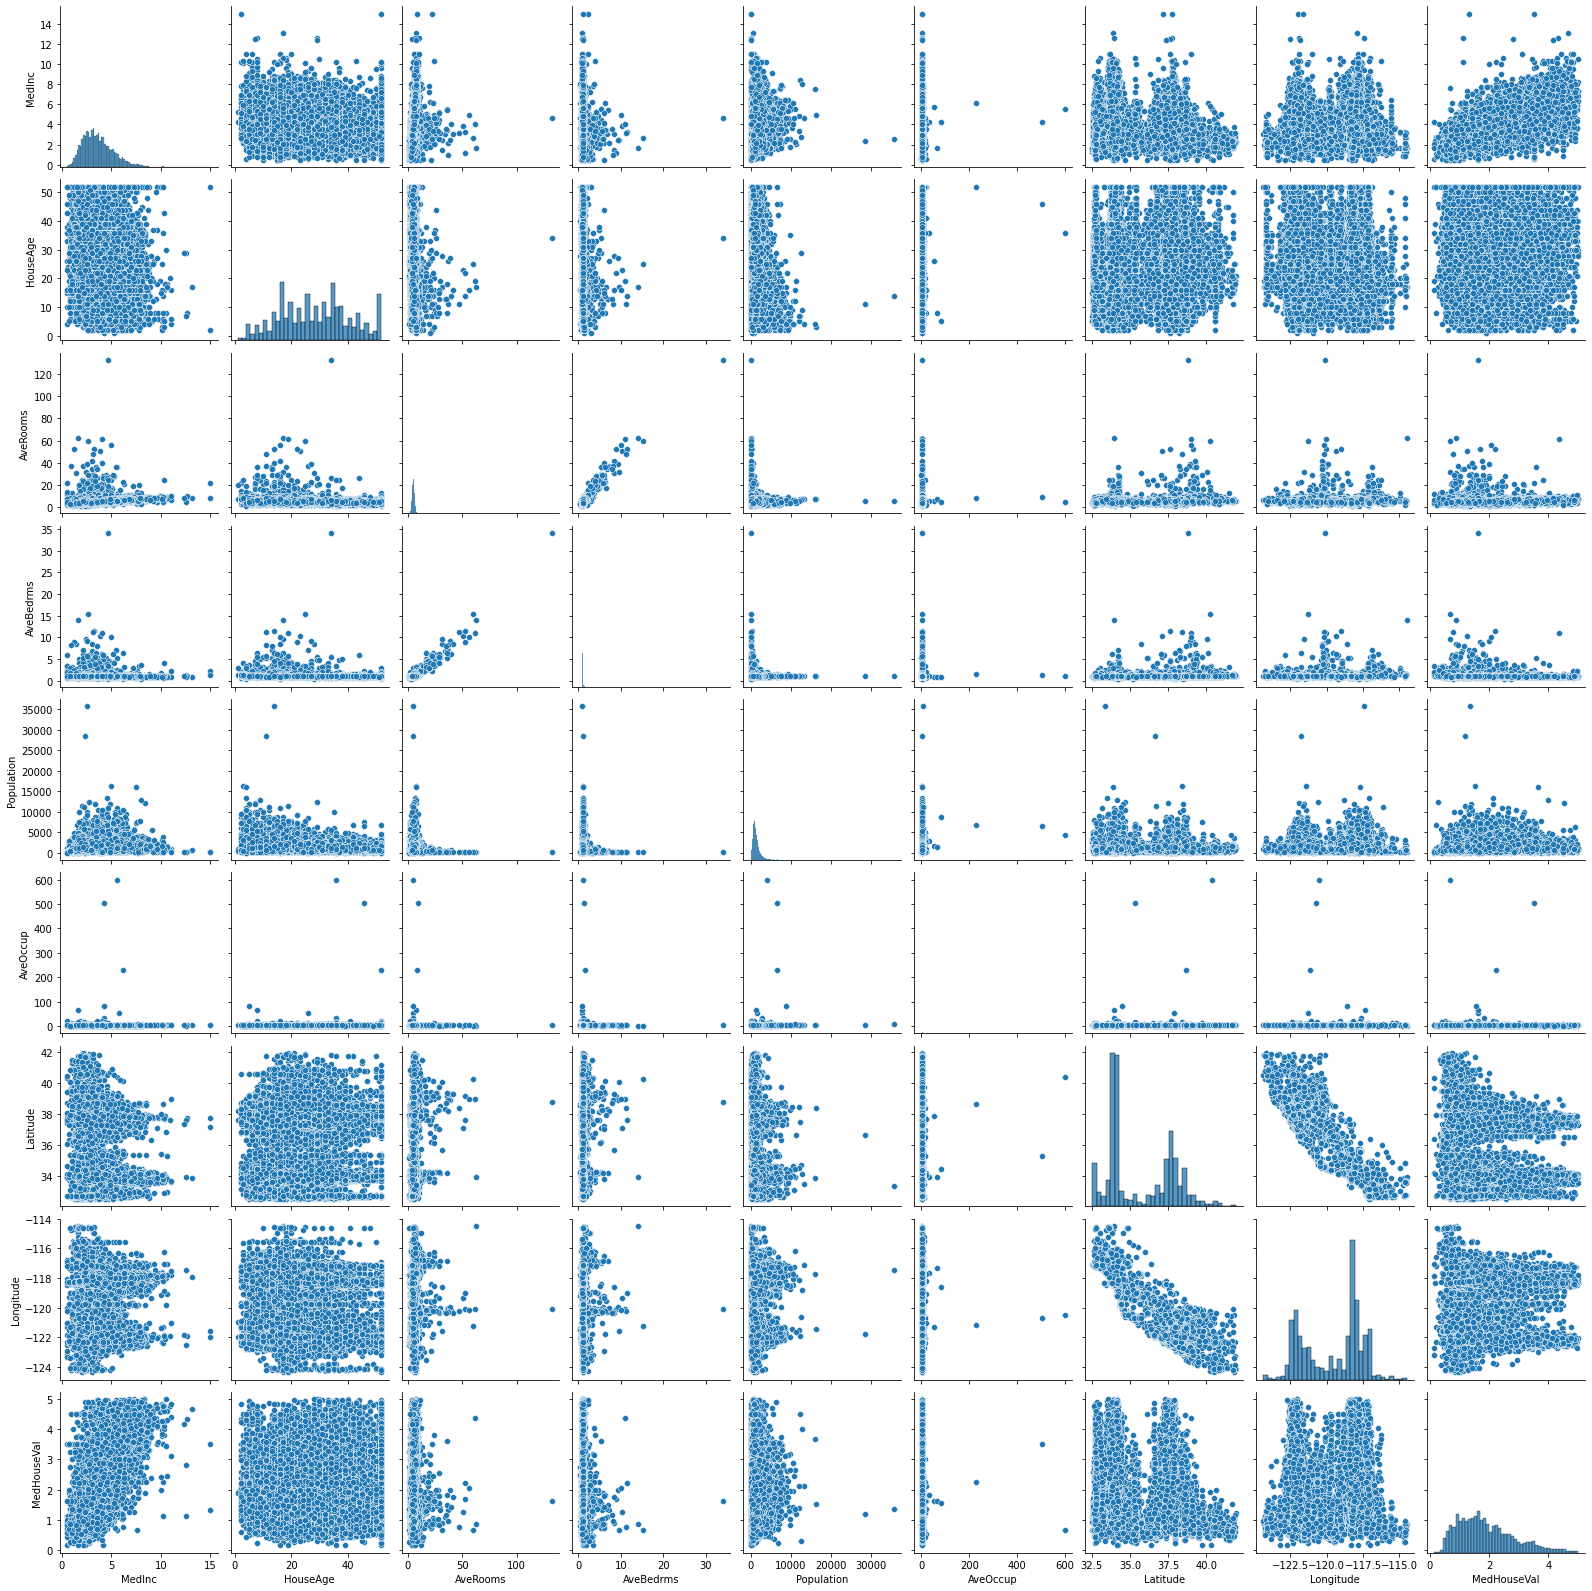

In [63]:
# scatterplot matrix
# sns.set()
cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']
sns.pairplot(data_train[cols], height = 2.5)
plt.show()

## Feature Preparation

### Median Income

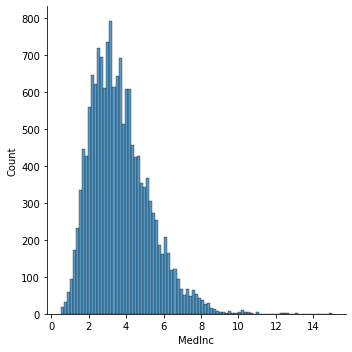

In [52]:
# Histogram
sns.displot(data=data_train, x="MedInc", )
plt.show()

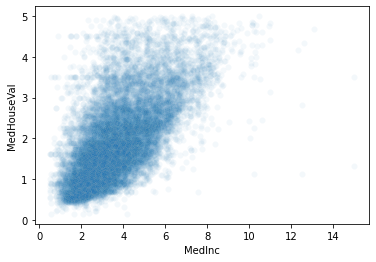

In [51]:
# Scatterplot with label
sns.scatterplot(data=data_train, x="MedInc", y="MedHouseVal", alpha=0.05)
plt.show()

In [66]:
medinc_nan_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # Replace missing values.
medinc_zero_imp = SimpleImputer(missing_values=0, strategy='most_frequent')  # Replace zero values.
medinc_std = StandardScaler()  # Standardize

medinc_preprocessor = Pipeline(steps=[
    ("medinc_nan_imp", medinc_nan_imp),
    ("medinc_zero_imp", medinc_zero_imp),
    ("medinc_std", medinc_std),
])

## Feature preparation: Preprocessor pipeline

In [67]:
preprocessor = ColumnTransformer(
    [
        ('medinc_preprocessor', medinc_preprocessor, ['MedInc',]),
    ],
    remainder='drop'
)

## Modelling

In [76]:
regressors = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
}

In [79]:
# Training and scoring
scores = {}
for rgr in regressors.keys():
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', regressors[rgr]),
    ])
    # full_pipeline.fit(X_train, y_train)
    # score = full_pipeline.score(X_test, y_test)
    # scores[rgr] = score
    cv_scores = cross_val_score(
        estimator=full_pipeline, 
        X=X_train, 
        y=y_train, 
        scoring='neg_mean_squared_error',
        cv=10)
    scores[rgr] = np.mean(np.sqrt(-cv_scores))
    print(".", end="")
print()    

sorted_scores = sorted([(value, key) for (key,value) in scores.items()], reverse=True)
for s in sorted_scores:
    print(f"{s[1]}: {s[0]:.3f}")

...
Decision Tree: 0.959
Random Forest: 0.858
Linear Regression: 0.740
